In [1]:
### TODO: calculate F_hourly
import intake
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
from skimage.segmentation import find_boundaries
import xesmf as xe
import dask.array as da
import scipy
from dask.distributed import progress
import pyproj
import warnings
import healpy as hp
import easygems.healpix as egh
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import glob
from dask.distributed import Client
import metpy.calc as mpcalc

In [2]:
import os
import sys

user_id = os.environ['USER']
sys.path.append(f'/home/548/{user_id}/working/hk25-AusNode-coastal/')

In [3]:
client = Client()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44383 instead
  warnings.warn(
2025-05-16 12:23:34,046 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-uas-17d75f36692b1edc74c68697b45a467a' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x146cab489bd0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayW

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44383/status,
Dashboard: /proxy/44383/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44439,Workers: 7
Dashboard: /proxy/44383/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:36713,Total threads: 4
Dashboard: /proxy/39689/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:36421,


In [13]:
#Open some sample data
ds = xr.open_zarr("/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z10.zarr/").sel(
    time=slice("2020-12-01 00:00","2020-12-01 23:00"))
#Open angles as defined in analysis/calculate_coastline_angles.py
angles = xr.open_zarr("/g/data/nf33/hk25_AusNode_coastal/um_MC_angles_z10.zarr/")
ds

2025-05-16 12:09:32,615 - distributed.utils_perf - WARNING - full garbage collections took 74% CPU time recently (threshold: 10%)


<xarray.Dataset> Size: 29GB
Dimensions:  (cell: 12582912, time: 24)
Coordinates:
  * cell     (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911
    crs      float64 8B ...
  * time     (time) datetime64[ns] 192B 2020-12-01 ... 2020-12-01T23:00:00
Data variables: (12/26)
    clivi    (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clt      (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clwvi    (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hflsd    (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hfssd    (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    huss     (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ...       ...
    rsutcs   (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    sftlf    (cell) float64 101MB dask.array<chunksize=(98304,), meta=np.ndarray>
    tas      (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ts       (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    uas      (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    vas      (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>

In [14]:
#Set up target lats and lons for interpolating the global data
nside = hp.get_nside(ds.uas)
ncells = ds.cell.shape[0]
nlats = int(np.round(np.sqrt(ncells/2)))
nlons = int(np.round(2*np.sqrt(ncells/2)))
target_lats = np.linspace(
    -90,
    90,
    nlats
)
target_lons = np.linspace(
    0,
    360,
    nlons,
)

#Slice down to MC for testing
target_lons = target_lons[(target_lons>=90) & (target_lons<=170)]
target_lats = target_lats[(target_lats>=-15) & (target_lats<=10)]

In [30]:
#Do the interpolation and return the healpix cell indices
from sea_breeze_code.utils import get_nn_lon_lat_index
target_inds = get_nn_lon_lat_index(nside, target_lons, target_lats)

#Define the regridded land sea mask
#lsm = ((ds.sftlf.isel(cell=target_inds))>0.5)

#Regrid u, v and hus in the same way as the land-sea mask
uas_regrid = ds.uas.isel(cell=target_inds)
vas_regrid = ds.vas.isel(cell=target_inds)
hus_regrid = ds.huss.isel(cell=target_inds)
tas_regrid = ds.huss.isel(cell=target_inds)
angle_regrid = angles.drop(("lat","lon")).angle_interp.isel(cell=target_inds)

2025-05-16 12:15:43,278 - distributed.utils_perf - WARNING - full garbage collections took 59% CPU time recently (threshold: 10%)
2025-05-16 12:15:44,372 - distributed.utils_perf - WARNING - full garbage collections took 58% CPU time recently (threshold: 10%)
2025-05-16 12:15:44,964 - distributed.utils_perf - WARNING - full garbage collections took 58% CPU time recently (threshold: 10%)
2025-05-16 12:15:45,638 - distributed.utils_perf - WARNING - full garbage collections took 58% CPU time recently (threshold: 10%)
2025-05-16 12:15:46,278 - distributed.utils_perf - WARNING - full garbage collections took 58% CPU time recently (threshold: 10%)
2025-05-16 12:15:46,938 - distributed.utils_perf - WARNING - full garbage collections took 58% CPU time recently (threshold: 10%)
2025-05-16 12:15:47,652 - distributed.utils_perf - WARNING - full garbage collections took 59% CPU time recently (threshold: 10%)
2025-05-16 12:15:48,300 - distributed.utils_perf - WARNING - full garbage collections took

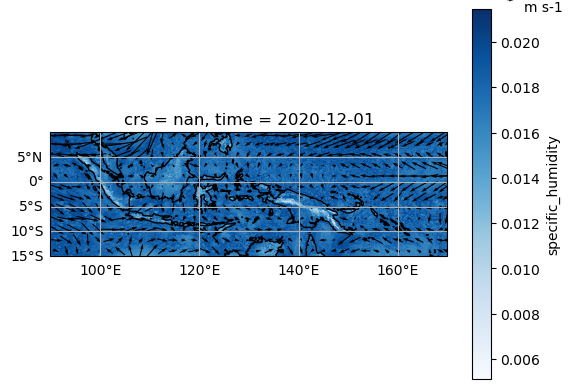

In [19]:
#Plot vprime and associated wind vectors for the first model time step
ax=plt.axes(projection=ccrs.PlateCarree())
im=hus_regrid.isel(time=0).plot(ax=ax, transform = ccrs.PlateCarree(),cmap="Blues")
xr.Dataset(
    {"u":uas_regrid,
    "v":vas_regrid}).isel(time=0).coarsen(
    {"lat":30,"lon":30},boundary="pad").mean()\
    .plot.quiver(
    x="lon",
    y="lat",
    u="u",
    v="v")
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"])

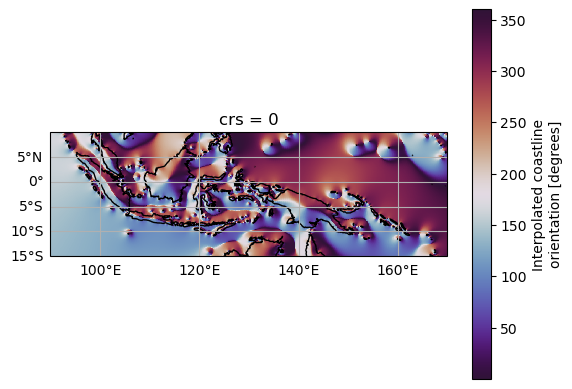

In [27]:
#Check the angles
ax=plt.axes(projection=ccrs.PlateCarree())
im=angle_regrid.plot(ax=ax, transform = ccrs.PlateCarree(),cmap="twilight_shifted")
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"])

In [28]:
#Calculate frontogenesis parameter
from sea_breeze_code.sea_breeze_funcs import kinematic_frontogenesis
F = kinematic_frontogenesis(hus_regrid,
                        uas_regrid,
                        vas_regrid
                       )

In [39]:
#Calculate hourly changes
from sea_breeze_code.sea_breeze_funcs import hourly_change, fuzzy_function_combine
F_hourly = hourly_change(hus_regrid,tas_regrid,uas_regrid,vas_regrid,angle_regrid)
F_fuzzy = fuzzy_function_combine(
    F_hourly["wind_change"],
    F_hourly["q_change"],
    F_hourly["t_change"],
    combine_method="mean")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 257.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [43]:
from sea_breeze_code.sea_breeze_filters import percentile, filter_3d

In [45]:
#Look at the percentiles to estimate a threshold for masking

print(np.array(percentile(F.F)))
print(np.array(percentile(F_fuzzy)))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 260.44 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.p

[53.5407153]
[0.22327429]


In [56]:
#Compute the sea breeze filtering
F_mask = filter_3d(
    F.F,
    angle_ds=angle_regrid,
    threshold="fixed",
    threshold_value=53.4,
    orientation_filter=False,
    propagation_speed_filter=False,
    save_mask=False,
    props_df_out_path='/scratch/ng72/ab4502/tmp/props_df.csv')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 16.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [57]:
F_fuzzy_mask = filter_3d(
    F_fuzzy,
    angle_ds=angle_regrid,
    threshold="fixed",
    threshold_value=0.22,
    orientation_filter=False,
    propagation_speed_filter=False,
    save_mask=False,
    props_df_out_path='/scratch/ng72/ab4502/tmp/props_df.csv')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 36.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


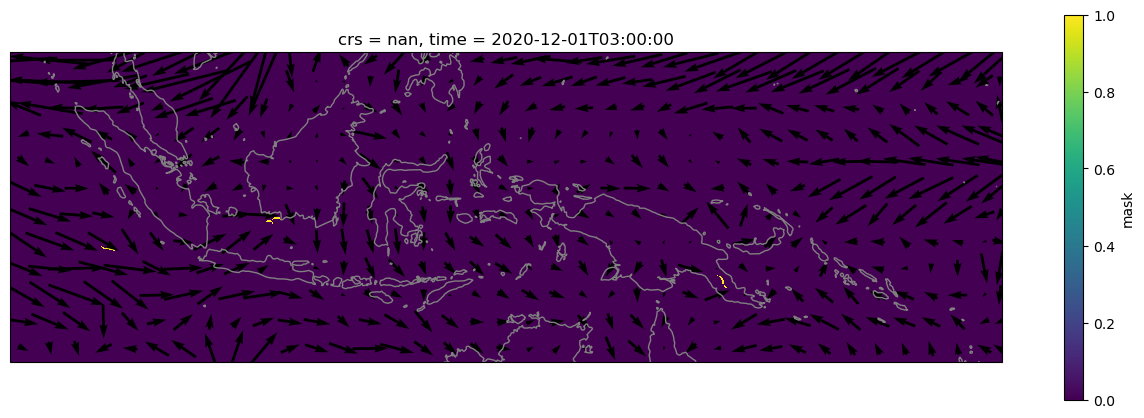

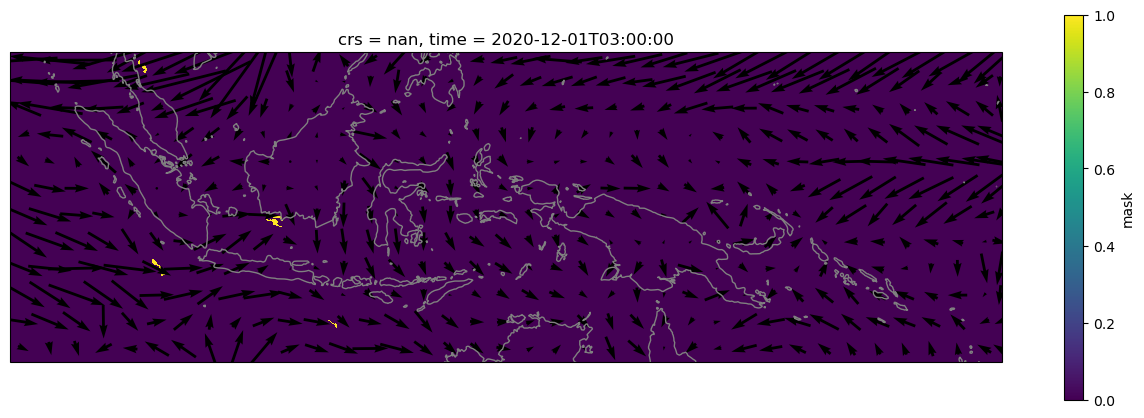

In [58]:
t=3

plt.figure(figsize=[16,5])

ax=plt.axes(projection=ccrs.PlateCarree())
F_mask.mask.isel(time=t).plot(ax=ax)
xr.Dataset(
    {"u":uas_regrid,
    "v":vas_regrid}).isel(time=t).coarsen(
    {"lat":30,"lon":30},boundary="pad").mean()\
    .plot.quiver(
    x="lon",
    y="lat",
    u="u",
    v="v")
ax.coastlines(color="grey")


plt.figure(figsize=[16,5])

ax=plt.axes(projection=ccrs.PlateCarree())
F_fuzzy_mask.mask.isel(time=t).plot(ax=ax)
xr.Dataset(
    {"u":uas_regrid,
    "v":vas_regrid}).isel(time=t).coarsen(
    {"lat":30,"lon":30},boundary="pad").mean()\
    .plot.quiver(
    x="lon",
    y="lat",
    u="u",
    v="v")
ax.coastlines(color="grey")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 269.38 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.p

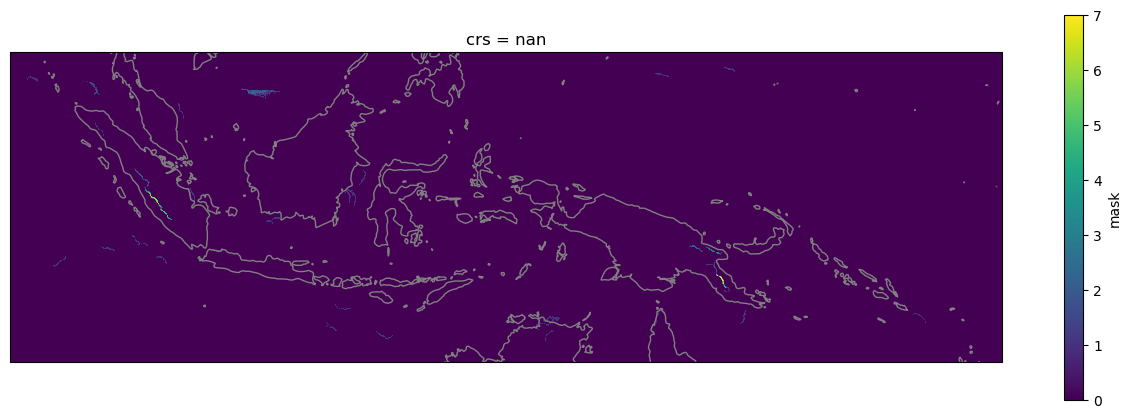

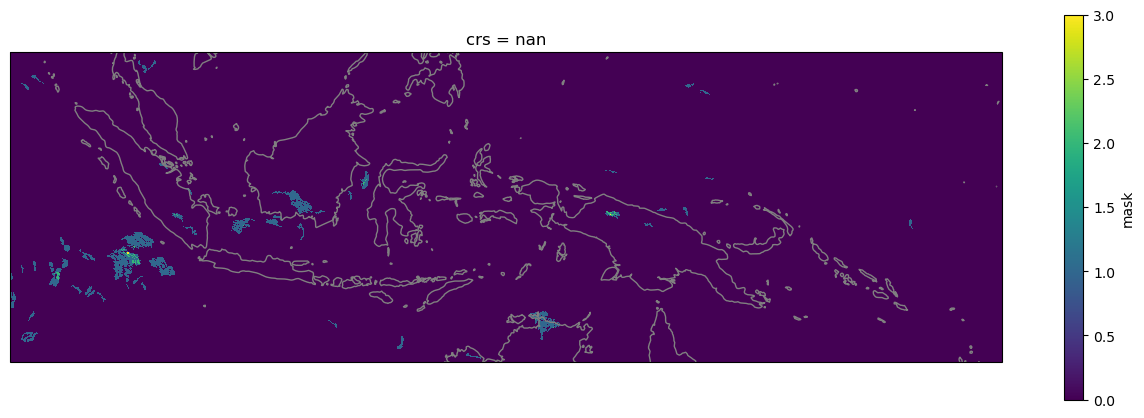

In [59]:
plt.figure(figsize=[16,5])

ax=plt.axes(projection=ccrs.PlateCarree())
F_mask.mask.sum("time").plot(ax=ax)
ax.coastlines(color="grey")


plt.figure(figsize=[16,5])

ax=plt.axes(projection=ccrs.PlateCarree())
F_fuzzy_mask.mask.sum("time").plot(ax=ax)
ax.coastlines(color="grey")